In [253]:
import warnings
warnings.filterwarnings('ignore')
import os
import seaborn as sns
from datetime import datetime
from matplotlib import pyplot as plt
import tensorflow as tf 
import math
import keras
import numpy as np
import pandas as pd
from sklearn.utils import class_weight
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [254]:
file: str = os.getcwd() + '/Data/train.xlsx'
file_test: str = os.getcwd() + '/Data/test.xlsx'
savePath: str = os.getcwd()

skiprows: int = 0
header: list = [0]
sheet_name: str = "detailled"
groundtruth:str = 'Survived'
dropColumns: list = ['Cabin', 'Ticket', 'First Name', 'Name', 'Log Fare Min Max']

In [255]:
dataframe: pd.DataFrame = pd.read_excel(os.getcwd() + '/Data/Dataset.xlsx', header=header, sheet_name=sheet_name, skiprows=skiprows)
dataframe.head(3)

PassengerId  Pclass First Name                    Name Civility     Sex  \
0          259       1       Ward                    Anna     Miss  female   
1          680       1    Cardeza   Thomas Drake Martinez       Mr    male   
2          738       1    Lesurer               Gustave J       Mr    male   

    Age  SibSp  Parch    Ticket      Fare  Log Fare        Cabin Embarked  \
0  35.0      0      0  PC 17755  512.3292  2.709549          NaN        C   
1  36.0      0      1  PC 17755  512.3292  2.709549  B51 B53 B55        C   
2  35.0      0      0  PC 17755  512.3292  2.709549         B101        C   

  Dataset  Survived  Log Fare Min Max  
0   train       1.0               1.0  
1   train       1.0               1.0  
2   train       1.0               1.0

<BarContainer object of 17 artists>

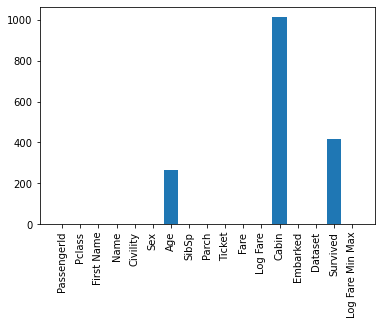

In [256]:
nanValues = dict((col, np.array(dataframe[col].isnull().values).sum()) for col in dataframe.columns)
plt.xticks(rotation=90)
plt.bar(*zip(*nanValues.items()))

# Conversion functions

In [257]:
def replace_titles(x):
    title=x['Civility']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

In [258]:
def PlotDistribution(df):
    dfnbr = [f for f in df.columns if df.dtypes[f] != 'object']
    f = pd.melt(df, value_vars=dfnbr)
    g = sns.FacetGrid(f, col="variable", col_wrap=4, sharex=False, sharey=False)
    g = g.map(sns.distplot, "value")

# Dataframe normalized

In [259]:
dataframe['Age'].fillna(value=dataframe['Age'].mean(), axis=0, inplace=True)

In [260]:
dataframe['Family_Size'] = dataframe['SibSp'] + dataframe['Parch'] + 1

In [261]:
dataframe[['Log Fare', 'Fare', 'Age', 'SibSp', 'Parch', 'Family_Size']] = MinMaxScaler().fit_transform(dataframe[['Log Fare', 'Fare', 'Age', 'SibSp', 'Parch', 'Family_Size']])
dataframe.head(2)

PassengerId  Pclass First Name                    Name Civility     Sex  \
0          259       1       Ward                    Anna     Miss  female   
1          680       1    Cardeza   Thomas Drake Martinez       Mr    male   

        Age  SibSp     Parch    Ticket  Fare  Log Fare        Cabin Embarked  \
0  0.436302    0.0  0.000000  PC 17755   1.0       1.0          NaN        C   
1  0.448829    0.0  0.111111  PC 17755   1.0       1.0  B51 B53 B55        C   

  Dataset  Survived  Log Fare Min Max  Family_Size  
0   train       1.0               1.0          0.0  
1   train       1.0               1.0          0.1

In [262]:
dataframe['Civility']=dataframe.apply(replace_titles, axis=1)

In [263]:
dataframe["Civility"] = dataframe["Civility"].astype('category').cat.codes
dataframe["Pclass"] = dataframe["Pclass"].astype('category').cat.codes
dataframe["Sex"] = dataframe["Sex"].astype('category').cat.codes
dataframe["Embarked"] = dataframe["Embarked"].astype('category').cat.codes
dataframe["Ticket"] = dataframe["Ticket"].astype('category').cat.codes

In [264]:
dataframe[['Civility', 'Pclass', 'Sex', 'Embarked']] = MinMaxScaler().fit_transform(dataframe[['Civility', 'Pclass', 'Sex', 'Embarked']])
dataframe.head(2)

PassengerId  Pclass First Name                    Name  Civility  Sex  \
0          259     0.0       Ward                    Anna  0.428571  0.0   
1          680     0.0    Cardeza   Thomas Drake Martinez  0.571429  1.0   

        Age  SibSp     Parch  Ticket  Fare  Log Fare        Cabin  Embarked  \
0  0.436302    0.0  0.000000     831   1.0       1.0          NaN  0.333333   
1  0.448829    0.0  0.111111     831   1.0       1.0  B51 B53 B55  0.333333   

  Dataset  Survived  Log Fare Min Max  Family_Size  
0   train       1.0               1.0          0.0  
1   train       1.0               1.0          0.1

In [265]:
dataframe.drop(dropColumns, axis=1, inplace=True)
dataframe = dataframe.set_index('PassengerId')

In [266]:
dataframe.head(2)

Pclass  Civility  Sex       Age  SibSp     Parch  Fare  Log Fare  \
PassengerId                                                                     
259             0.0  0.428571  0.0  0.436302    0.0  0.000000   1.0       1.0   
680             0.0  0.571429  1.0  0.448829    0.0  0.111111   1.0       1.0   

             Embarked Dataset  Survived  Family_Size  
PassengerId                                           
259          0.333333   train       1.0          0.0  
680          0.333333   train       1.0          0.1

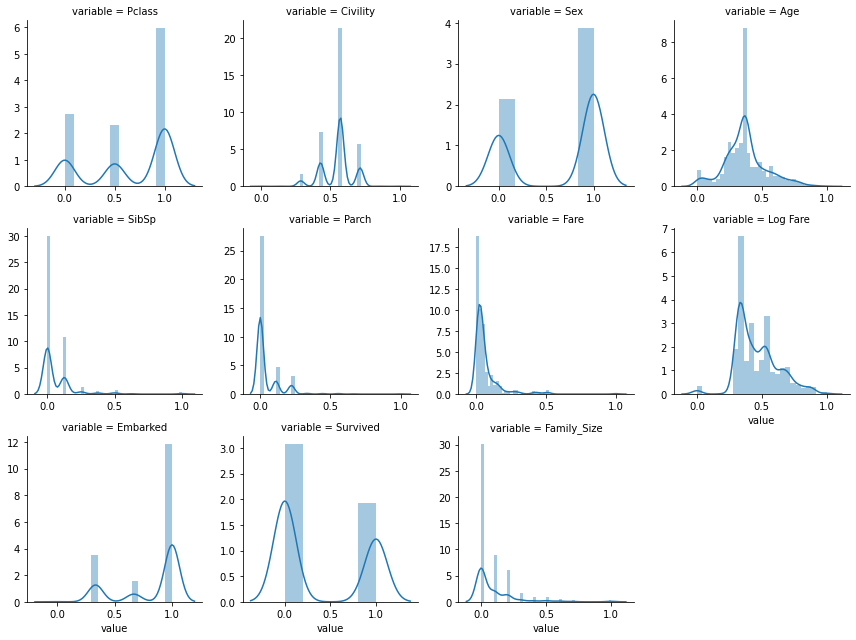

In [267]:
PlotDistribution(dataframe)

# Dataframe as dummies

In [268]:
dataframe_dummies: pd.DataFrame = pd.read_excel(os.getcwd() + '/Data/Dataset.xlsx', header=header, sheet_name=sheet_name, skiprows=skiprows)

In [269]:
dataframe_dummies.head()

PassengerId  Pclass First Name                    Name Civility     Sex  \
0          259       1       Ward                    Anna     Miss  female   
1          680       1    Cardeza   Thomas Drake Martinez       Mr    male   
2          738       1    Lesurer               Gustave J       Mr    male   
3           28       1    Fortune       Charles Alexander       Mr    male   
4           89       1    Fortune             Mabel Helen     Miss  female   

    Age  SibSp  Parch    Ticket      Fare  Log Fare        Cabin Embarked  \
0  35.0      0      0  PC 17755  512.3292  2.709549          NaN        C   
1  36.0      0      1  PC 17755  512.3292  2.709549  B51 B53 B55        C   
2  35.0      0      0  PC 17755  512.3292  2.709549         B101        C   
3  19.0      3      2     19950  263.0000  2.419956  C23 C25 C27        S   
4  23.0      3      2     19950  263.0000  2.419956  C23 C25 C27        S   

  Dataset  Survived  Log Fare Min Max  
0   train       1.0          1.000000  
1   train       1.0          1.000000  
2   train       1.0          1.000000  
3   train       0.0          0.893121  
4   train       1.0          0.893121

In [270]:
dataframe_dummies['Civility']=dataframe_dummies.apply(replace_titles, axis=1)

In [271]:
dataframe_dummies['Family_Size'] = dataframe_dummies['SibSp'] + dataframe_dummies['Parch'] + 1

In [272]:
dataframe_dummies['Cabin'] = dataframe_dummies['Cabin'].fillna('U')

In [273]:
dataframe_dummies['Cabin'] = dataframe_dummies['Cabin'].map(lambda x: x[0])

In [274]:
most_embarked = dataframe_dummies['Embarked'].value_counts().index[0]
dataframe_dummies['Embarked'] = dataframe_dummies['Embarked'].fillna(most_embarked)

In [275]:
dataframe_dummies['Fare'] = dataframe_dummies['Fare'].fillna(dataframe['Fare'].median())

In [276]:
dataframe_dummies['Age'] = dataframe_dummies['Age'].fillna(value=dataframe['Age'].mean(), axis=0)

In [277]:
dataframe_dummies[['Fare']] = MinMaxScaler().fit_transform(dataframe_dummies[['Fare']])

In [278]:
dataframe_dummies.head(2)

PassengerId  Pclass First Name                    Name Civility     Sex  \
0          259       1       Ward                    Anna     Miss  female   
1          680       1    Cardeza   Thomas Drake Martinez       Mr    male   

    Age  SibSp  Parch    Ticket  Fare  Log Fare Cabin Embarked Dataset  \
0  35.0      0      0  PC 17755   1.0  2.709549     U        C   train   
1  36.0      0      1  PC 17755   1.0  2.709549     B        C   train   

   Survived  Log Fare Min Max  Family_Size  
0       1.0               1.0            1  
1       1.0               1.0            2

In [279]:
dataframe_dummies.drop(['First Name', 'Name', 'Log Fare', 'Log Fare Min Max', 'Ticket'], axis=1, inplace=True)
dataframe_dummies.head(2)

PassengerId  Pclass Civility     Sex   Age  SibSp  Parch  Fare Cabin  \
0          259       1     Miss  female  35.0      0      0   1.0     U   
1          680       1       Mr    male  36.0      0      1   1.0     B   

  Embarked Dataset  Survived  Family_Size  
0        C   train       1.0            1  
1        C   train       1.0            2

In [280]:
pclass_dummies = pd.get_dummies(dataframe_dummies['Pclass'], prefix="Pclass")
cabin_dummies = pd.get_dummies(dataframe_dummies['Cabin'], prefix="Cabin")
embarked_dummies = pd.get_dummies(dataframe_dummies['Embarked'], prefix="Embarked")
family_size_dummies = pd.get_dummies(dataframe_dummies['Family_Size'], prefix="Family_Size")
sex_dummies = pd.get_dummies(dataframe_dummies['Sex'], prefix="Sex")
civility_dummies = pd.get_dummies(dataframe_dummies['Civility'], prefix="Civility")
age_dummies = pd.get_dummies(dataframe_dummies['Age'], prefix="Age")
sibsp_dummies = pd.get_dummies(dataframe_dummies['SibSp'], prefix="SibSp")
parch_dummies = pd.get_dummies(dataframe_dummies['Parch'], prefix="Parch")

In [281]:
titanic_dummies = pd.concat([pclass_dummies, 
                             cabin_dummies,
                             embarked_dummies,
                             family_size_dummies,
                             sex_dummies,
                             civility_dummies,
                             age_dummies,
                             sibsp_dummies,
                             parch_dummies, 
                             dataframe_dummies['Fare'],
                             dataframe_dummies['PassengerId'],
                             dataframe_dummies['Dataset'],
                             dataframe_dummies['Survived']],
                             axis=1)

titanic_dummies = titanic_dummies.set_index('PassengerId')

In [282]:
titanic_dummies

Pclass_1  Pclass_2  Pclass_3  Cabin_A  Cabin_B  Cabin_C  Cabin_D  \
PassengerId                                                                     
259                 1         0         0        0        0        0        0   
680                 1         0         0        0        1        0        0   
738                 1         0         0        0        1        0        0   
28                  1         0         0        0        0        1        0   
89                  1         0         0        0        0        1        0   
...               ...       ...       ...      ...      ...      ...      ...   
1267                1         0         0        0        0        0        0   
945                 1         0         0        0        0        1        0   
961                 1         0         0        0        0        1        0   
1235                1         0         0        0        1        0        0   
1044                0         0         1        0        0        0        0   

             Cabin_E  Cabin_F  Cabin_G  ...  Parch_1  Parch_2  Parch_3  \
PassengerId                             ...                              
259                0        0        0  ...        0        0        0   
680                0        0        0  ...        1        0        0   
738                0        0        0  ...        0        0        0   
28                 0        0        0  ...        0        1        0   
89                 0        0        0  ...        0        1        0   
...              ...      ...      ...  ...      ...      ...      ...   
1267               0        0        0  ...        0        0        0   
945                0        0        0  ...        0        1        0   
961                0        0        0  ...        0        0        0   
1235               0        0        0  ...        1        0        0   
1044               0        0        0  ...        0        0        0   

             Parch_4  Parch_5  Parch_6  Parch_9      Fare  Dataset  Survived  
PassengerId                                                                   
259                0        0        0        0  1.000000    train       1.0  
680                0        0        0        0  1.000000    train       1.0  
738                0        0        0        0  1.000000    train       1.0  
28                 0        0        0        0  0.513342    train       0.0  
89                 0        0        0        0  0.513342    train       1.0  
...              ...      ...      ...      ...       ...      ...       ...  
1267               0        0        0        0  0.512122     test       NaN  
945                0        0        0        0  0.513342     test       NaN  
961                1        0        0        0  0.513342     test       NaN  
1235               0        0        0        0  1.000000     test       NaN  
1044               0        0        0        0  0.000055     test       NaN  

[1309 rows x 151 columns]

# Save preprocess dataframe

In [47]:
newDf: str = os.getcwd() + '/Data/Preprocess Data.xlsx'
    
with pd.ExcelWriter(newDf, mode='rw') as writer:  
    dataframe.to_excel(writer, sheet_name='Data')

In [283]:
newDf: str = os.getcwd() + '/Data/Preprocess Data Dummies.xlsx'
    
with pd.ExcelWriter(newDf, mode='rw') as writer:  
    titanic_dummies.to_excel(writer, sheet_name='Data')